In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import os
from time import time

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)  # 过滤掉 Tensorflow 的 Warning 信息

import tensorflow.examples.tutorials.mnist.input_data as input_data
import numpy as np
import matplotlib.pyplot as plt

### 1. 数据预处理

In [3]:
mnist = input_data.read_data_sets('data/', one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [4]:
print('train images shape:', mnist.train.images.shape)
print('train labels shape:', mnist.train.labels.shape)
print()
print('validation images shape:', mnist.validation.images.shape)
print('validation labels shape:', mnist.validation.labels.shape)
print()
print('test images shape:', mnist.test.images.shape)
print('test labels shape:', mnist.test.labels.shape)

train images shape: (55000, 784)
train labels shape: (55000, 10)

validation images shape: (5000, 784)
validation labels shape: (5000, 10)

test images shape: (10000, 784)
test labels shape: (10000, 10)


### 2. 建立模型

#### 2.1 定义 layer 函数

In [5]:
def layer(output_dim, input_dim, inputs, activation=None):
    W = tf.Variable(tf.random_normal([input_dim, output_dim]))
    b = tf.Variable(tf.random_normal([1, output_dim]))
    result = tf.matmul(inputs, W) + b
    
    if activation is None:
        outputs = result
    else:
        outputs = activation(result)
    
    return outputs

#### 2.2 建立输入层

In [6]:
x = tf.placeholder('float', [None, 784])

#### 2.3 建立隐藏层

In [7]:
h1 = layer(output_dim=256, input_dim=784, inputs=x, activation=tf.nn.relu)

#### 2.4 建立输出层

In [8]:
y_predict = layer(output_dim=10, input_dim=256, inputs=h1, activation=None)

### 3. 定义训练方式

#### 3.1 建立训练数据 label 真实值的 placeholder

In [9]:
y_label = tf.placeholder('float', [None, 10])

#### 3.2 定义损失函数

In [10]:
loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_predict, labels=y_label))

#### 3.3 定义优化器

In [11]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss_function)

### 4. 定义评估模型准确率的方式

#### 4.1 计算每一项数据是否预测正确

In [12]:
correct_prediction = tf.equal(tf.argmax(y_label, axis=1), tf.argmax(y_predict, axis=1))

#### 4.2 计算预测正确结果的平均值

In [13]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

### 5. 开始训练

In [14]:
train_epochs = 15
batch_size = 100
total_batch = int(mnist.train.num_examples / batch_size)
epoch_list = []
loss_list = []
acc_list = []

In [15]:
start_time = time()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(train_epochs):
    for i in range(total_batch):
        x_batch, y_batch = mnist.train.next_batch(batch_size=batch_size)
        sess.run(optimizer, feed_dict={x: x_batch, y_label: y_batch})
    
    loss, acc = sess.run([loss_function, accuracy], 
                         feed_dict={x: mnist.validation.images, y_label: mnist.validation.labels})
    epoch_list.append(epoch+1)
    loss_list.append(loss)
    acc_list.append(acc)
    print('train epoch:', '%02d' % (epoch + 1), 'loss:', '{:.9f}'.format(loss), 'acc:', acc)

print()
print('train finished. takes', time() - start_time, 'seconds')

train epoch: 01 loss: 6.757495403 acc: 0.8368
train epoch: 02 loss: 4.420877934 acc: 0.8854
train epoch: 03 loss: 3.375313997 acc: 0.9038
train epoch: 04 loss: 2.792876720 acc: 0.91
train epoch: 05 loss: 2.404265642 acc: 0.9208
train epoch: 06 loss: 2.152849913 acc: 0.9242
train epoch: 07 loss: 1.942529678 acc: 0.9256
train epoch: 08 loss: 1.796358347 acc: 0.931
train epoch: 09 loss: 1.639527202 acc: 0.9368
train epoch: 10 loss: 1.564802527 acc: 0.9388
train epoch: 11 loss: 1.503402591 acc: 0.9392
train epoch: 12 loss: 1.392196417 acc: 0.9442
train epoch: 13 loss: 1.427558780 acc: 0.9424
train epoch: 14 loss: 1.377343774 acc: 0.9472
train epoch: 15 loss: 1.309303880 acc: 0.9476

train finished. takes 27.56218981742859 seconds


### 6. 以图形显示训练过程

In [16]:
def show_train_history(x_values, y_values, title):
    plt.plot(x_values, y_values, label=title)
    plt.xlabel('Epoch')
    plt.ylabel(title)
    plt.legend([title], loc='upper left')
    plt.show()

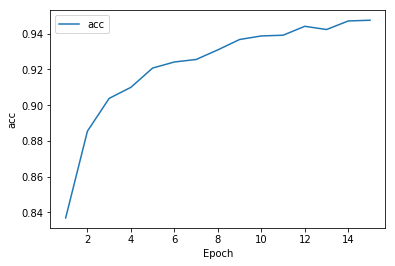

In [17]:
show_train_history(epoch_list, acc_list, 'acc')

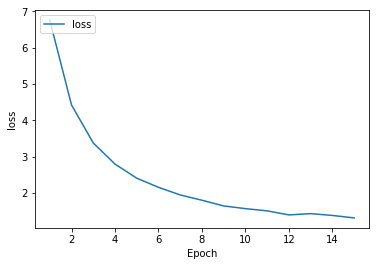

In [18]:
show_train_history(epoch_list, loss_list, 'loss')

### 7. 评估模型准确率

In [19]:
print('accuracy:', sess.run(accuracy, feed_dict={x: mnist.test.images, y_label: mnist.test.labels}))

accuracy: 0.9424


### 8. 进行预测

#### 8.1 执行预测

In [20]:
prediction_result = sess.run(tf.argmax(y_predict, axis=1), feed_dict={x: mnist.test.images})

#### 8.2 预测结果

In [21]:
prediction_result[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9])

#### 8.3 定义函数以显示10项预测结

In [22]:
def plot_images_labels_prediction(images, labels, predictions, idx, num=10):
    """
    images: 数字图像数组
    labels: 真实值数组
    predictions: 预测结果数据
    idx: 开始显示的数据index
    num: 要显示的数据项数, 默认为10, 不超过25
    """
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num > 25:
        num = 25
    for i in range(0, num):
        ax = plt.subplot(5, 5, i+1)
        ax.imshow(images[idx].reshape(28, 28), cmap='binary')
        title = 'lable=' + str(np.argmax(labels[idx]))
        if len(predictions) > 0:
            title += ',predict=' + str(predictions[idx])
        ax.set_title(title, fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        idx += 1
    plt.show()

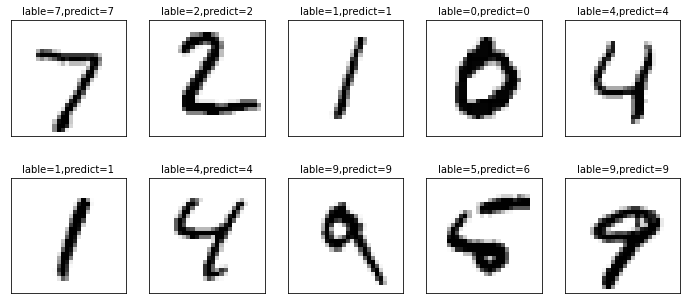

In [23]:
plot_images_labels_prediction(mnist.test.images, mnist.test.labels, prediction_result, 0, 10)

### 9. 找出预测错误

In [24]:
for i in range(300):
    label = np.argmax(mnist.test.labels[i])
    predict = prediction_result[i]
    if predict != label:
        print('i=' + str(i), 'label=' + str(label), 'predict=' + str(predict))

i=8 label=5 predict=6
i=33 label=4 predict=6
i=66 label=6 predict=2
i=96 label=1 predict=3
i=115 label=4 predict=8
i=212 label=9 predict=3
i=241 label=9 predict=8
i=245 label=3 predict=6
i=247 label=4 predict=6
i=259 label=6 predict=0
i=261 label=5 predict=3
i=264 label=9 predict=8
i=268 label=8 predict=9
i=274 label=9 predict=3


In [25]:
sess.close()